# Airline Satisfaction - Classification

The following dataframe was imported from kaggle.com. It presents reviews of a certain airline made by close to 130 thousand people. Each person is identified by his/her ID number followed by some identifying features of the person and the type of flight and the review of said person in several different categories (explained further down in the notebook). The review system is to give a 0–5-star rating for each category. This is followed by a concluding column of whether the person was overall "satisfied" with the airline and the flight or was "neutral or dissatisfied".<br>
Link to the dataset on kaggle: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction<br><br>

Our purpose in this notebook is to determine whether a given passenger not from the dataframe given, provided all the data of the passenger's review except the last column where he/she stated the overall satisfaction, was satisfied with the airline or not (in other words: which of the 2 possible answers the passenger would choose: "satisfied" or "neutral or dissatisfied").

In [1]:
#Importing the libraries used
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

We next must import the dataframe into the notebook. The dataframe was divided on kaggle.com to the train and test set. We shall first combine the 2 dataframes into a single one so as not to apply all changes to both dataframes (to be divided later on in the notebook back into the train and test set, although not necessarily the same ones as on download).<br>
On upload of the .csv files into jupyter as dataframes, an index is added to the dataframes, leaving the initial id as a column of no significance ("Unnamed: 0"). On merging the 2 datasets, again, we give the dataframe a new index, but due to both columns name being "index" we first rename the index column, then apply the reset_index() function, then drop the column now named "i".<br>
Henceforth, we shall refer to the whole dataset "fulldf" instead of the train and test sets imported to the notebook (until it is again divided).

In [2]:
defaultTest = pd.read_csv('Data/Airline Satisfaction/Import/test.csv') #importing the dataframe 'test.csv' from the appropriate folder
defaultTrain = pd.read_csv('Data/Airline Satisfaction/Import/train.csv') #importing the dataframe 'train.csv' from the appropriate folder
fulldf = pd.concat([defaultTest, defaultTrain]) #merging  the 2 datasets, so that we can work as if we were given the undivided
#dataset in the first place.
fulldf.index.name = 'i' #renaming the index column so that the new index will not have the same name as the old
fulldf = fulldf.reset_index() #Resetting the indexes for appearance's sake.
fulldf = fulldf.drop(['i', 'Unnamed: 0'], axis = 1) #removing the columns of indexes which we changed: the change was not
#necessary, only for the sake of appearance
fulldf

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
129876,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
129877,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
129878,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [3]:
fulldf.groupby(['Class', 'Gender']).count()['id']

Class     Gender
Business  Female    31263
          Male      30897
Eco       Female    29670
          Male      28639
Eco Plus  Female     4966
          Male       4445
Name: id, dtype: int64

## Data Cleaning

Before delving into the data cleaning, we first must understand what it is that we must do. To do that, we first check whether there are any duplicates in the data provided. Because all reviewer have a unique ID, it is enough to check whether there are 2 reviews (2 records in the dataset) with the same ID. To do that, we group the dataset by ID using groupby() and check if the size of any of the groups provided is greater than 1 (as we can see below). From this we can gather that no duplicate IDs exist, hence there are no duplicate reviews in the dataset.

In [4]:
dupl = fulldf.groupby(['id']).size()>1
dupl.value_counts()
#Checking that there are no duplicates (no values that are true)

False    129880
dtype: int64

After checking the dataset for duplicates, we no longer need the ID attribute, as it is of little to no use in predicting the overall satisfaction of the reviewer.

In [5]:
fulldf = fulldf.drop(['id'], axis = 1) #Further unneded attribute

Let us first examine the dataset we now have using info(). Here we can see the name of every attribute, the count of non-null values for each attribute and the type of data each attribute has. Keeping in mind that the dataset has 129880 records, we can derive that the only attribute that has NaN values is "Arrival Delay in Minutes". We will have to deal with it in a minute. Further on, as seen below, there are several attributes where the type of data is "object". From a quick review of the dataset, we can see that it is a string, which for the purposes of machine learning we shall have to encode as numerical values.

In [6]:
fulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

To encode the attributes with strings we first must understand what kinds of strings each attribute presents. From the code below we can see that every attribute with strings, has only a small number of possible values, for example: the attribute "Gender" has only 2 possible values: "Male" and "Female". All other values for attributes can be seen below, with the number of values of each value for each attribute.

In [7]:
print('Gender:\n', fulldf['Gender'].value_counts(), '\n')
print('Customer Type:\n', fulldf['Customer Type'].value_counts(), '\n')
print('Type of Travel:\n', fulldf['Type of Travel'].value_counts(), '\n')
print('Class:\n', fulldf['Class'].value_counts(), '\n')
print('satisfaction:\n', fulldf['satisfaction'].value_counts(), '\n')

Gender:
 Female    65899
Male      63981
Name: Gender, dtype: int64 

Customer Type:
 Loyal Customer       106100
disloyal Customer     23780
Name: Customer Type, dtype: int64 

Type of Travel:
 Business travel    89693
Personal Travel    40187
Name: Type of Travel, dtype: int64 

Class:
 Business    62160
Eco         58309
Eco Plus     9411
Name: Class, dtype: int64 

satisfaction:
 neutral or dissatisfied    73452
satisfied                  56428
Name: satisfaction, dtype: int64 



Now that we know what each "object" attribute consists of (in terms of values), we can encode them as we see fit. The most logical encoding (for me at least), is one with integers from 0 onward, where 0 is the "worst" of the options and going upwards with the numbers up to the best, unless it has absolutely no meaning and no "worst" or "best" as is the case with the "Gender" and "Type of Travel" attributes.

In [8]:
#Encoding values from string to numerical

fulldf['Gender'] = fulldf['Gender'].replace({"Male": 0, "Female": 1})
fulldf['satisfaction'] = fulldf['satisfaction'].replace({"neutral or dissatisfied": 0, "satisfied": 1})
fulldf['Type of Travel'] = fulldf['Type of Travel'].replace({"Personal Travel": 0, "Business travel": 1})
fulldf['Customer Type'] = fulldf['Customer Type'].replace({"disloyal Customer": 0, "Loyal Customer": 1})
fulldf['Class'] = fulldf['Class'].replace({"Eco": 0, "Eco Plus": 1, "Business": 2})
fulldf

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,1,52,1,0,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,1
1,1,1,36,1,2,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,1
2,0,0,20,1,0,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,0
3,0,1,44,1,2,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,1
4,1,1,49,1,0,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1,0,23,1,0,192,2,1,2,3,...,2,3,1,4,2,3,2,3,0.0,0
129876,0,1,49,1,2,2347,4,4,4,4,...,5,5,5,5,5,5,4,0,0.0,1
129877,0,0,30,1,2,1995,1,1,1,3,...,4,3,2,4,5,5,4,7,14.0,0
129878,1,0,22,1,0,1000,1,1,1,5,...,1,4,5,1,5,4,1,0,0.0,0


Below are the histograms of every attribute and the with the attribute values as the x axis and the number of records with said value in said attribute as the y axis. For our purposes, it is of almost no significance, except to visually understand the approximate distributions of values over the dataframe. This is needed in turn to understand that the data is not "capped" on either end (for example), meaning that the actual values were not rounded to a certain value if they were above that value, and likewise below. Another use for the histograms is seeing that there are sufficient records for most if not all values of every attribute, for example if all reviewers were men, there will be no point of that attribute for the model's purposes.

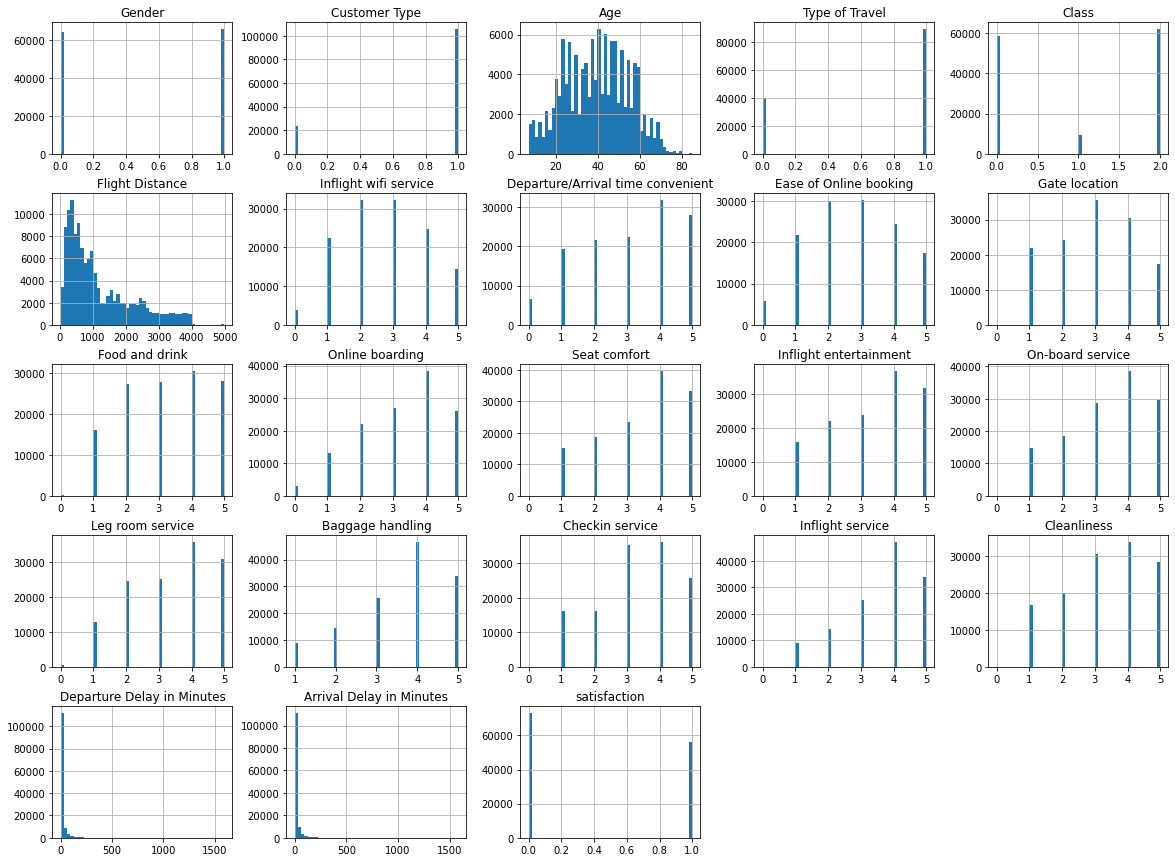

In [9]:
fulldf.hist(bins=50, figsize=(20,15))
plt.show()

### Dealing with NaN values
Below, we list the records which have NaN values in any cell. As we know from before, the only attribute that has NaN values is "Arrival Delay in Minutes", so all the records listed below have the value of said attribute as NaN.

In [10]:
fulldf[fulldf.isna().any(axis=1)]

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
516,1,1,21,0,0,632,1,5,1,4,...,2,4,2,5,4,5,2,9,NaN,0
656,0,1,9,0,0,762,2,5,2,2,...,4,2,5,2,5,2,4,51,NaN,0
1071,0,0,25,1,0,1017,3,4,4,5,...,5,2,5,2,3,2,5,126,NaN,0
1224,0,1,7,0,0,399,4,5,4,4,...,4,4,3,1,1,4,4,0,NaN,0
1589,1,1,58,1,0,129,5,3,3,3,...,5,5,5,5,3,5,5,3,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128043,0,1,49,0,1,1249,2,5,2,3,...,3,4,5,4,3,4,3,230,NaN,0
128360,0,1,58,1,0,733,3,3,3,3,...,3,3,1,2,4,2,3,55,NaN,0
128528,1,0,29,1,0,1107,2,1,1,1,...,5,4,1,5,5,3,5,0,NaN,0
128936,0,1,58,1,0,1088,4,4,1,1,...,5,1,5,5,5,3,5,0,NaN,1


Below we create a dataframe of correlations between every attribute with one another. The dataframe represents the linear correlation between the attributes (nonlinear relations have very low values as the functions considers only linear relations). The values range between -1 and 1, where positive values represent positive relations ("as X increases, Y increases"), while negative value represent negative relations ("as X increases, Y decreases"). All attribute has an exact linear relation with itself (1.0000). A final thing to not is that the table presented has many duplicates (we could remove the upper right triangle (if the table were cut diagonally from the upper-left corner to the lower-right corner), and not lose any data).<br>
Using this data, we plot a heatmap using seaborn, to better and easier see the higher values.

<AxesSubplot:>

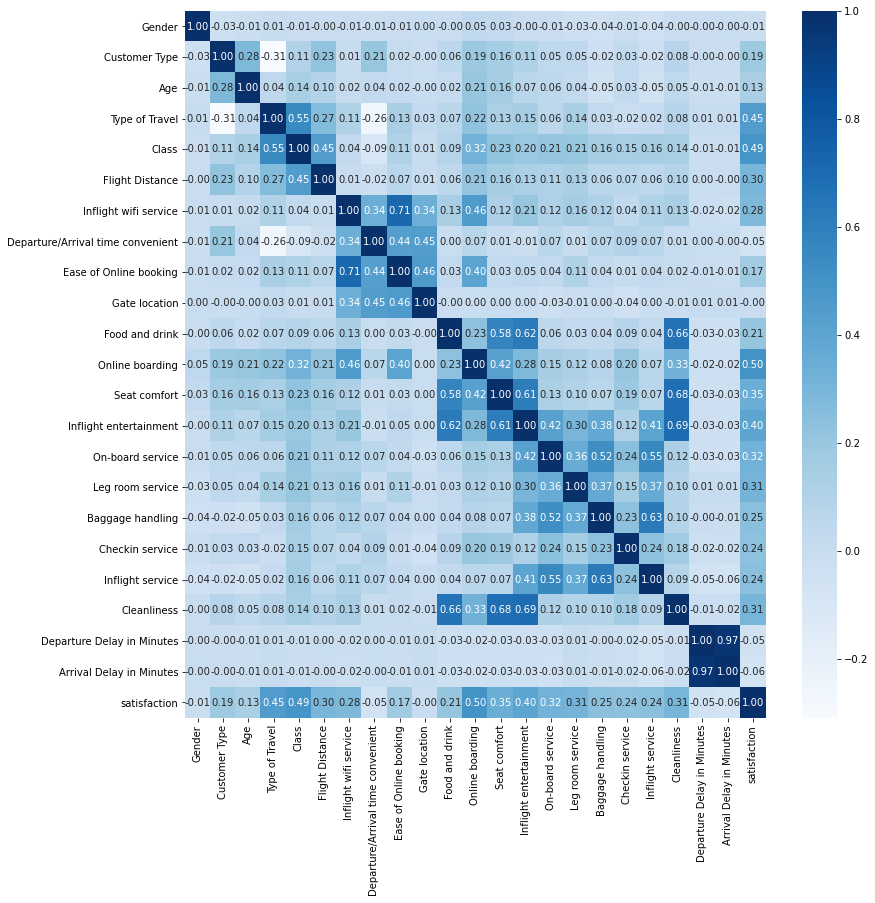

In [11]:
plt.figure(figsize=(13,13))
sns.heatmap(fulldf.corr(), cmap = 'Blues', annot=True, fmt=".2f")

We can see from the correlation function above that the attributes "Arrival Delay in Minutes" and "Departure Delay in Minutes" have an extremely high linear correlation (0.9653), and, although not an exact duplicate, as we have NaN values for of the "Arrival Delay in Minutes" and not of "Departure Delay in Minutes", we can copy values from the later to the former, where needed. Again, it is not a perfect match, nor do we expect the values copied to be an exact replica of what happened in reality, their effect on the dependent variable (the satisfaction) remains the same. All that remains, after making the decision, is to make said changes, which is done below.<br>
To visualize the codependence of the 2 attributes, we shall plot a scatter graph using seaborn - Although most values are at the bottom left-hand corner, the tendency is undeniable.

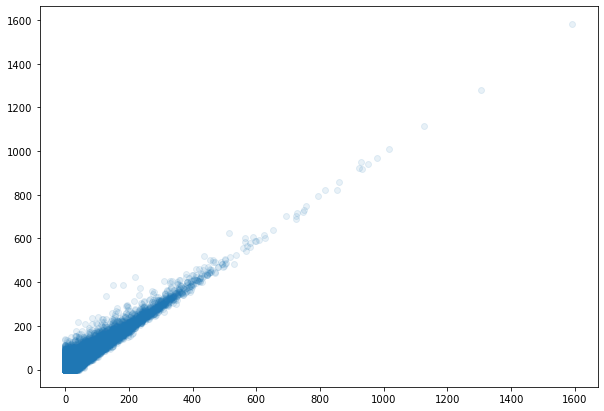

In [12]:
fig = plt.figure(figsize = (10,7))
plt.scatter(fulldf['Departure Delay in Minutes'], fulldf['Arrival Delay in Minutes'], alpha = 0.1)

In [13]:
fulldf['Arrival Delay in Minutes'].fillna(fulldf['Departure Delay in Minutes'], inplace = True)

Next, due to the 2 attributes having so close a relation (as mentioned in the cell above), we can remove the unneeded attribute. We define which of the 2 is unneeded by checking which has a slightly closer linear relation to the overall satisfaction.

In [14]:
fulldf = fulldf.drop(['Departure Delay in Minutes'], axis = 1) #removing the departure delay in minutes -
#correlation is 0.96 - very high, no need for both as one follows mostly from the other

In [15]:
fulldf.info() #Presenting the final dataset info before maachine learning algorithms for future reference

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  int64  
 1   Customer Type                      129880 non-null  int64  
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  int64  
 4   Class                              129880 non-null  int64  
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

One last thing we must do before we split the data into train and test sets, we must normalize the values. As all are values are now numerical, and there are no NaN values, we can do that without too much trouble. The normalization will only be done on the values which will be given to us in the future for prediction (all data except the attribute which we have decided to predict: the overall satisfaction of the reviewer). In this case, the overall satisfaction is already normalized as it comprises of values 0 and 1 only, but in general it is not necessary to normalize the attribute for prediction.<br>
We choose normalization and not standardization due to there being no outliers in this dataset.<br><br>
To normalize the data, we first split it to x and y, and mentioned above.

In [16]:
x = fulldf.drop(['satisfaction'], axis = 1)
y = fulldf['satisfaction']

Next, we use the function min_max_scaler.fit_transform() to achieve normalization of the data.

In [17]:
z = x.values #returns a numpy array
min_max_scaler = MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(z)
x = pd.DataFrame(z_scaled)
x

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,1.0,0.576923,1.0,0.0,0.026050,1.0,0.8,0.6,0.8,...,0.8,0.6,1.0,1.0,1.0,1.00,0.4,1.0,1.0,0.027778
1,1.0,1.0,0.371795,1.0,1.0,0.571890,0.2,0.2,0.6,0.2,...,0.8,1.0,0.8,0.8,0.8,0.75,0.6,0.8,1.0,0.000000
2,0.0,0.0,0.166667,1.0,0.0,0.032512,0.4,0.0,0.4,0.8,...,0.4,0.4,0.4,0.8,0.2,0.50,0.4,0.4,0.4,0.000000
3,0.0,1.0,0.474359,1.0,1.0,0.675687,0.0,0.0,0.0,0.4,...,0.8,0.8,0.2,0.2,0.2,0.00,0.6,0.2,0.8,0.003788
4,1.0,1.0,0.538462,1.0,0.0,0.232431,0.4,0.6,0.8,0.6,...,0.2,0.4,0.4,0.4,0.4,0.25,0.8,0.4,0.8,0.012626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1.0,0.0,0.205128,1.0,0.0,0.032512,0.4,0.2,0.4,0.6,...,0.4,0.4,0.4,0.6,0.2,0.75,0.4,0.6,0.4,0.000000
129876,0.0,1.0,0.538462,1.0,1.0,0.467690,0.8,0.8,0.8,0.8,...,0.8,1.0,1.0,1.0,1.0,1.00,1.0,1.0,0.8,0.000000
129877,0.0,0.0,0.294872,1.0,1.0,0.396607,0.2,0.2,0.2,0.6,...,0.2,1.0,0.8,0.6,0.4,0.75,1.0,1.0,0.8,0.008838
129878,1.0,0.0,0.192308,1.0,0.0,0.195679,0.2,0.2,0.2,1.0,...,0.2,0.2,0.2,0.8,1.0,0.00,1.0,0.8,0.2,0.000000


## Models
Now that we are finished with data cleaning, we have a dataset, where there are no NaN values, all attributes are numerical and normalized, we can split the data using the train_test_split() method. The method splits the data according to a random state (an integer), so that over multiple reruns, the resulting dataframes from the method remain the same. The test size is set to 0.1 (10%), which results in close to 13000 records (which is enough in my opinion).

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

### Dummy Classifier

Now that we have split our data, we can get down to the models. Before choosing and applying the models to the data, we need a baseline model, to compare all others to it: if the models thereafter are worse than the base model, we are doing something wrong. If the model is better than the base model, on the other hand, it means that the model works, and can be better at predicting than a "dummy" model. The base model we will use is "Dummy Classifier", which will, regardless of the input, put in the most frequent value in y_train. It puts in the most frequent value due to the strategy we have put into the model, although we could choose differently, but this strategy seems to return the best results.<br><br>

after using the model.fit() and model.predict() methods, we can use the metrics.accuracy_score() method to test a see which percentage of the predictions made by the dummy classifier were correct. in our case, the percentage of correct answers is 56.7%. Not bad, although not unexpected, as it almost certainly would have to be over 50%, as out of the 2 options, the dummy classifier chose the one which appeared the most.

In [19]:
dummyModel = DummyClassifier(strategy="most_frequent")
dummyModel.fit(X_train, y_train)
predictionsDummy = dummyModel.predict(X_test)

accuracyDummy = metrics.accuracy_score(y_test, predictionsDummy)
accuracyDummy

0.5637511549122267

We shall plot a confusion matrix to visualize how many values the dummy classifier predicted correctly (the confusion matrix is explained in detail later in the notebook.

<AxesSubplot:>

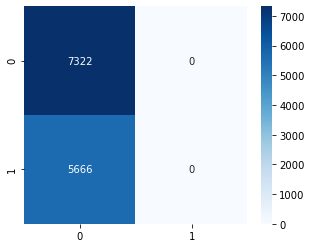

In [20]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsDummy), cmap = "Blues", annot=True, fmt = '.0f')

### KNN: K Nearest Neighbor

Now that we know what we strive for (a model that returns an accuracy of more than 0.56), we can start applying a model to the data that does something more than the dummy classifier. We will first use the KNN model. The KNN model (K nearest Neighbors) is one that chooses the value closest to the values from the train set. if K = 1, then it chooses depending on the single closest neighbor to the wanted data; if N > 1, then it chooses the label depending on the N closest neighbors (in terms of data). The "weights" parameter specifies whether the model is to give a higher penalty for the neighbors further away or to count their value as equally valuable to determine the label.<br><br>

In the cell below we run a function, which purpose is to determine the best N value, meaning the number of neighbors for which the data works best. True, the differences seem not very significant between the different values, but I believe it gives perspective.<br>
*Note: Due to the function run time being abysmal (several minutes), we will save the results in a different variable, and put the function call as a comment, so as not to delay the running of the notebook.

In [21]:
def chooseKNN():
    maxi = 1 #saving the index of the highest score
    max = 0 #saving the value of the highest score
    for i in range(1,20):
        modelKNN = KNeighborsClassifier(n_neighbors = i, weights='distance')
        modelKNN.fit(X_train, y_train)
        accuracy = modelKNN.score(X_test, y_test)
        if (accuracy > max):
            maxi = i
            max = accuracy
    print(maxi, "  ", max)
#chooseKNN()
#The value for maxi returned was: 9
#The value for max was: 0.9335540498922081

We have identified the best number of neighbors for this data: 9. We shall run the model one last time to record the predictions made, to calculate the model's accuracy using measures other than the built in score() method.

In [22]:
modelKNN = KNeighborsClassifier(n_neighbors = 9, weights='distance')
modelKNN.fit(X_train, y_train)
predictionsKNN = modelKNN.predict(X_test)
accuracyKNN = metrics.accuracy_score(y_test, predictionsKNN) #Resturns the same value as the score() method in the
#previous cell
accuracyKNN

KeyboardInterrupt: 

Below we calculate the best cv parameter (K-folds) value for the cross-validation score. We run from 1 to 20. The cv value in cross validation score means the number of "folds" the training set is divided into.<br>

Cross validation is when we divide the training set into a certain number of parts of identical length. There are made this certain number of runs, when for each run, a different one of the divided sets is set aside. The model runs as in the usual training set, then another "piece" of the training set is used. Their performances are recorded, and the mean value is displayed.<br><br>

We have identified after these runs that 19 is the best number of k-folds for this data (out of the given range at least). As we were hoping, the r2 score matches (almost) the r2 score of the original model, meaning the model works as expected, without overfitting or underfitting (most probably).<br>

*Note: As with KNN value, due to the function run time being abysmal (several minutes), we will save the results in a different variable, and put the function call as a comment, so as not to delay the running of the notebook.

In [ ]:
def chooseKFold(model):
    maxi = 1 #saving the index of the highest score
    max = 0 #saving the value of the highest score
    for i in range(2,20):
        accuracy = cross_val_score(model, X_train, y_train, cv = i).mean()
        if (accuracy > max):
            maxi = i
            max = accuracy
    print('Best index:', maxi, "\ncross_val_score of index", maxi, ':', max)

In [24]:
#chooseKFold(modelKNN)
#The value for maxi returned was: 19
#The value for max was: 0.9317832165238031

<a id='confusion'></a>
We now want to know exactly how well our model has performed on the task at hand. We shall plot a confusion matrix to understand how many of the answers the model got wrong and right per label for the test set.<br>
Each cell from left to right and top to bottom: The model said 0 and it was 0, the model said 1 and it was 0, the model said 1 and it was 0, the model said 1 and it was 1.<br>
This is of course, where 0 is "neutral or dissatisfied" and 1 is "satisfied".<br>
In other words, the diagonal cells from top left corner are the value the model predicted correctly, all others (in this case only 2), are the ones the model predicted incorrectly.<br>
Another thing to note, is that in general, the confusion matrix is built thus: The x axis represents the predicted labels, whereas the y axis represents the actual labels.<br>
The confusion matrix is shown as a heatmap using seaborn.

<AxesSubplot:>

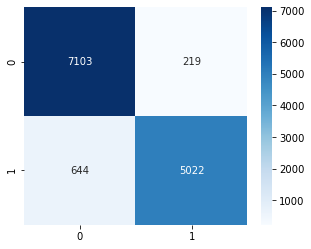

In [25]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsKNN), cmap = "Blues", annot=True, fmt = '.0f')

Next, we want to show the "classification report" of the model at hand (KNN). The report shows us several things:
- Precision - Here are 2 values:<br>
    Precision for 0: out of all predicted 0'es, how many were predicted correct? the answer according to the report is 0.92, or 92%.<br>
    Precision for 1: out of all predicted 1's, how many were predicted correct? the answer according to the report is 0.96, or 96%.<br>
    The equation for precision is:
    $$ Precision = \frac{TruePositive}{TruePositive + FalsePositive} $$<br>

- Recall - Here are 2 values:<br>
    Precision for 0: out of all true 0'es, how many were predicted correct? the answer according to the report is 0.97, or 97%.<br>
    Precision for 1: out of all true 1's, how many were predicted correct? the answer according to the report is 0.89, or 89%.<br>
    The equation for precision is:
    $$ Recall = \frac{TruePositive}{TruePositive + FalseNegative} $$<br>
    
- F1 score - The overall evaluation of the model. calculated by the equation for each value:
  $$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall} $$<br>

- Accuracy - How many predictions were made correctly. The report shows us that the accuracy of the KNN model is 0.93, or 93%

- Support - The column states the number of true occurrences of each of the 2 values in the dataset, as well as them combined (the last 3 values of support)

In [26]:
print(classification_report(y_test, predictionsKNN))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7322
           1       0.96      0.89      0.92      5666

    accuracy                           0.93     12988
   macro avg       0.94      0.93      0.93     12988
weighted avg       0.93      0.93      0.93     12988



### Logistic Regression

For our second model we will choose Logistic Regression. This model is chosen because it makes no assumptions regarding the distribution of labels, it works according to probabilities which it calculates for each record in the dataframe, and it is a fairly simple model that yet works well with many datasets. The model tries to fit an S shape to the data (as opposed to linear regression that fits a straight line), where the edges of the S are values where the probability is very high for a label to occur, and closer to the middle of the S, it is lower. We can also set a threshold "on the S", from which the model will predict a certain value. This is usually done when a certain value is preferred over the other. As we try to be objective with the reviews, we will not do it.<br><br>
As done with the KNN model, we define the model, use fit() and predict() methods and calculate and present the accuracy of the model, in this case 0.87 or 87%

In [27]:
modelLogReg = LogisticRegression()
modelLogReg.fit(X_train, y_train)
predictionsLogReg = modelLogReg.predict(X_test)
accuracyLogReg = modelLogReg.score(X_test, y_test)
accuracyLogReg

0.8728826609177702

Below, again, the function for identifying the optimal k-fold was called. As is clearly visible, the result is very similar to the original model of Logistic Regression, meaning the model works as should, without overfitting or underfitting (most probably).

In [28]:
#chooseKFold(modelLogReg)
print('The values returned by the function were:\n', 'The optimal K-fold is: 12 and its score is 0.8742771104951578')

The values returned by the function were:
 The optimal K-fold is: 12 and its score is 0.8742771104951578


As in KNN, we show the confusion matrix as a heatmap and the classification report.

<AxesSubplot:>

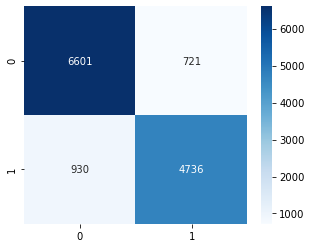

In [29]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsLogReg), cmap = "Blues", annot=True, fmt = '.0f')

In [30]:
print(classification_report(y_test, predictionsLogReg))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7322
           1       0.87      0.84      0.85      5666

    accuracy                           0.87     12988
   macro avg       0.87      0.87      0.87     12988
weighted avg       0.87      0.87      0.87     12988



<a id='ROC'></a>
In the following cells, we will plot the ROC curve for the 3 models we have. The ROC curve describes the performance of the model/s according to the confusion matrix. With the changes in thresholds from the default (0.5 in our case), so does change the confusion matrix, and more specifically the ratio between the right and the left columns of it. As one increases, the other decreases. Likewise, when a bottom cell of a certain column increases, so does the other one in the same column. The later relationship is shown plainly as the ROC curve.<br>
To plot the curve, we first calculate and save the probabilities of every model we want to present. The probabilities are returned as a 2D array, but we only need a single column. The second column ("1") was chosen. we use the metrics.roc_curve() method to return 3 values, the first 2 of which will be used as the x and y axis as their names imply (fpr = false positive rate; trp = true positive rate).<br>
The code that comes after is the plotting of the graphs, the naming of axis and the showing of legend.

In [31]:
probsKNN = modelKNN.predict_proba(X_test)[:, 1]
probsLogReg = modelLogReg.predict_proba(X_test)[:, 1]
dummyProbs = dummyModel.predict_proba(X_test)[:, 1]

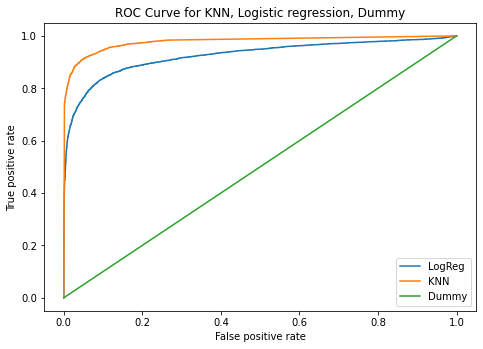

In [32]:
fprLR, tprLR, thresholdsLR = metrics.roc_curve(y_test, probsLogReg)
fprKNN, tprKNN, thresholdsKNN = metrics.roc_curve(y_test, probsKNN)
fprDummy, tprDummy, thresholdsDummy = metrics.roc_curve(y_test, dummyProbs)
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(fprLR, tprLR, label = "LogReg")
axes.plot(fprKNN, tprKNN, label = "KNN")
axes.plot(fprDummy, tprDummy, label = "Dummy")
axes.set_xlabel("False positive rate")
axes.set_ylabel("True positive rate")
axes.set_title("ROC Curve for KNN, Logistic regression, Dummy")
axes.legend()

For absolution, we seek to calculate the AUC of each model: the area under the ROC curve. Using the built-in method metrics.auc() to calculate. The results are plain. Out of the 3 models shown, the KNN is the best, although the logistic regression is not bad too. The dummy, as predicted, should not be used.

In [33]:
print('AUC of Logistic Regression model:', metrics.auc(fprLR, tprLR))
print('AUC of KNN model:', metrics.auc(fprKNN, tprKNN))
print('AUC of Dummy model:', metrics.auc(fprDummy, tprDummy))

AUC of Logistic Regression model: 0.9248094052487305
AUC of KNN model: 0.9779561771153629
AUC of Dummy model: 0.5


Let us show the accuracy scores of the 3 models:

Text(0.5, 1.0, 'Accuracy Scores of the different models')

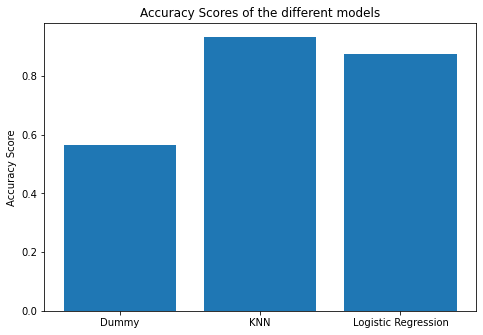

In [34]:
fig = plt.figure()
accuracies = [accuracyDummy, accuracyKNN, accuracyLogReg]
accuraciesSize = np.arange(len(accuracies))
axes = fig.add_axes([0,0,1,1])
axes.bar(['Dummy', 'KNN', 'Logistic Regression'], accuracies)
axes.set_ylabel("Accuracy Score")
axes.set_title("Accuracy Scores of the different models")

To conclude, we have tested 2 models (3 if you count the dummy) on the dataset to determine passenger’s satisfaction of the airline after they have taken the survey. The best model out of the 3 is undoubtedly the KNN (for this specific dataset). With a high accuracy rate (0.93) and a high value of the AUC of the ROC curve.

# ---------------------------------------------------------------

# Continuing from first semester henceforth...

The purpose of the continuation of this notebook is to try and improve the performance of the classifiers from the first semester, using the techniques newly learned and examined. Moreover, a bigger accent will be put on runtime of the models, with a slighly less "accuracy only" approach. Naturally, we are not certain that such an improvement can be made, especially with our already high accuracy rate.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import warnings
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
#Relevant imports

The models we will use all use Ensemble learning to achieve the desired result. The idea of Ensemble learning is to use multiple predictions from different sources and from them extrapolate the final result which the models return. Due to the estimators being unbiased by one another, there cannot be overfitting in such models (with large numbers of estimators), hence we need not worry in creating "too much" estimators, as they correct one another and thus remove overfitting from equation. So why not use an almost infinite number of estimators? That is for 2 reasons, the first being is that with large number of estimators, the runtime of the fitting of models becomes increasingly larger, making the process inefficient. The second reason is that after a certain number of estimators, the use of additional estimators becomes less and less useful, as they have corrected each other "as much as they were going to correct". In most cases, the accuracy will still rise with the number of estimators, but more slowly. Together, the 2 reasons prevent us from rationalizing the use of "too large" number of estimators (although we must still take care to choose the correct number of estimators, to maximize accuracy while minimizing the runtime of the program). For each model and each dataset, the ideal number of estimators differ and must be considered individually.

The strength of Ensemble Learning is its use of "weak learners" (classifiers with an accuracy slightly higher than 50%), since the combinations of weak classifiers many times (in the tens, hundreds, or thousands) produce exceptional results. Of course, the better the classifier - the more accurate the completed model shall most likely be, but accuracy is not always the deciding factor, but rather the runtime of the program: while an ensemble of "strong learners" may be more accurate (not necessarily the case), the program using them will usually run much slower than the one using "weak learners". Again, the results usually are quite close in terms of accuracy to make such exceptions.

As accuracy is currently not our only concern, we want to see the difference that the PCA algorithm makes when using it on this data (PCA explained later). For the purposes of learning and understanding the concepts better, we shall see the difference of accuracy vs. runtime for each model. First, we shall see the results of the models without PCA, then use PCA and run the classifiers again. Then, we shall see the differences in performance between the approaches.

We shall calculate the runtime of each model, to better understand the best option of models for this data.

In the classifiers below, the hyperparameter tuning was mostly done using educated guesses and trial and error. After the best classifier was found, a grid search was run to maximize the results.

For each classifier, we shall plot a [confusion matrix](#confusion) and print a classification report in order to better understand the results (explained in previously in this notebook).

First, we can check the accuracy received when using the <b>Random Forests Classifier</b>. This classifier uses ensemble learning by constructing a multitude of decision trees (specified with the n_estimators hyperparameter, defaults at 100), without a maximum depth of each tree (such depth can be added using the max_depth hyperparameter, but after several tests, the result was that not limiting the trees is best in the case of this data). After several tests, the number of estimators was set to 500, as the best correlation of time and resource consumption.<br>
For the test set, each trees prediction is calculated, the results then aggregated, and the final answer is given. The aggregation is performed by each trees result counted and the "majority vote" is the final answer of the classifier.

In [46]:
#Random Forests
start_timeRandForests = time.time()
modelRandForests = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 0)
modelRandForests.fit(X_train, y_train)
predictionsRandForests = modelRandForests.predict(X_test)
accuracyRandForests = metrics.accuracy_score(y_test, predictionsRandForests)
print("Accuracy (Random Forests): ", accuracyRandForests)
timeRandForests = time.time() - start_timeRandForests
print("Time taken to achive result: %s seconds" % (timeRandForests))

Accuracy (Random Forests):  0.9634277794887589
Time taken to achive result: 8.866713523864746 seconds


<AxesSubplot:>

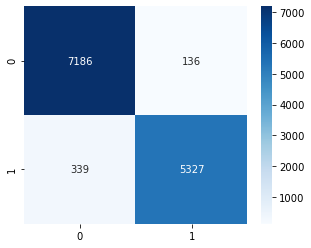

In [47]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsRandForests), cmap = "Blues", annot=True, fmt = '.0f')

In [48]:
print(classification_report(y_test, predictionsRandForests))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7322
           1       0.98      0.94      0.96      5666

    accuracy                           0.96     12988
   macro avg       0.97      0.96      0.96     12988
weighted avg       0.96      0.96      0.96     12988



Next, we will check the performance of the <b>AdaBoost Classifier</b> (AdaBoost stands for Adaptive Boost). This classifier also uses ensemble learning to achieve its purpose. After receiving the results from some base classifier, in our case the Decision Tree Classifier, the model then performs the base classifier over and over (n_estimator times), while each time giving more weight to the misclassified training instances. Then, again using ensemble learning techniques the model returns its final answer according to the many sub-models it created.<br>
The learning rate hyperparameter was left at the default value of 1 (after several tests to determine the best value). The hyperparameter specifies the rate of adaptability of the classifier to the data after each iteration of the estimator.

In [49]:
#AdaBoost
start_timeAdaBoost = time.time()
modelDecTree = DecisionTreeClassifier(random_state=0, max_depth=2)
modelAdaBoost = AdaBoostClassifier(modelDecTree, n_estimators = 1000, random_state = 0, learning_rate = 1)
modelAdaBoost.fit(X_train, y_train)
predictionsAdaBoost = modelAdaBoost.predict(X_test)
accuracyAdaBoost = metrics.accuracy_score(y_test, predictionsAdaBoost)
print("Accuracy (AdaBoost): ", accuracyAdaBoost)
timeAdaBoost = time.time() - start_timeAdaBoost
print("Time taken to achive result: %s seconds" % (timeAdaBoost))

Accuracy (AdaBoost):  0.9575762242069603
Time taken to achive result: 105.26763963699341 seconds


<AxesSubplot:>

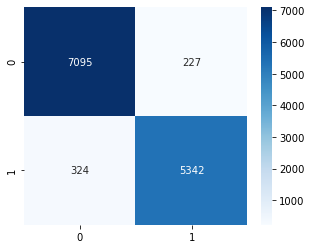

In [50]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsAdaBoost), cmap = "Blues", annot=True, fmt = '.0f')

In [51]:
print(classification_report(y_test, predictionsAdaBoost))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7322
           1       0.96      0.94      0.95      5666

    accuracy                           0.96     12988
   macro avg       0.96      0.96      0.96     12988
weighted avg       0.96      0.96      0.96     12988



Last of the single models (but certainly not least), we shall run the <b>XGBoost Classifier</b> on our data (XGBoost standing for Extreme Gradient Boosting, which uses Ensemble Learning and boosting in a similar yet different way to AdaBoost above. Where AdaBoost tweaks the individual instance weights, giving some more or less wight, XGBoost fits a new predictor to the residual errors made by the previous predictor. It should be noted that the residual errors get smaller with each iteration of XGBoost, making the model very effective (in many cases the most effective out of all).

In [52]:
#XGBoost
start_timeXGBoost = time.time()
warnings.filterwarnings('ignore')
modelXGBoost = XGBClassifier(learning_rate = 0.2, n_estimators = 200, verbosity = 0, use_label_encoder = False, n_jobs = -1)
modelXGBoost.fit(X_train, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test)
accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achive result: %s seconds" % (timeXGBoost))

Accuracy (XGBoost):  0.9655066214967662
Time taken to achive result: 3.468726396560669 seconds


<AxesSubplot:>

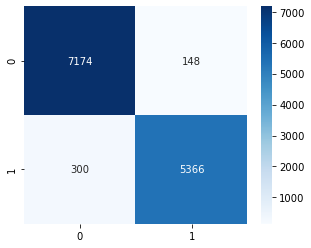

In [53]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')

In [54]:
print(classification_report(y_test, predictionsXGBoost))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7322
           1       0.97      0.95      0.96      5666

    accuracy                           0.97     12988
   macro avg       0.97      0.96      0.96     12988
weighted avg       0.97      0.97      0.97     12988



Now that all models are trained, and they are not bad at all, we can try to combine them and get "the best out of all worlds". This we shall first try by using the <b>Voting Classifier</b>. This classifier takes the results of each model (given in the "estimators" hyperparameter), and compares the results given by each model for every record of the dataframe, returning the value that most classifiers agree on. The voting method was changed to "soft", meaning that from each classifier, the probability of each result will be considered ("how sure the classifier is that its final decision is correct"), rather than the raw "yes or no" in the case of "hard" voting method. The weights of each model in the evaluation are also given, for we know that the last 3 classifiers had much better results than the first two.

In [55]:
#Voting
start_timeVoting = time.time()
warnings.filterwarnings('ignore')
modelVoting = VotingClassifier(
    estimators=
        [('KNN', modelKNN),
         ('LogReg', modelLogReg),
         ('RandForests', modelRandForests),
         ('AdaBoost', modelAdaBoost),
         ('XGBoost', modelXGBoost)],
    voting='soft', n_jobs=-1, weights=[1,1,3,3,3])
modelVoting.fit(X_train, y_train)
predictionsVoting = modelVoting.predict(X_test)
accuracyVoting = metrics.accuracy_score(y_test, predictionsVoting)
print("Accuracy: ", accuracyVoting)
timeVoting = time.time() - start_timeVoting
print("Time taken to achive result: %s seconds" % (timeVoting))

Accuracy:  0.9654296273483215
Time taken to achive result: 148.0000650882721 seconds


<AxesSubplot:>

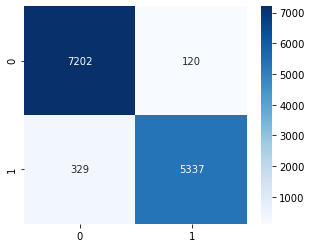

In [56]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsVoting), cmap = "Blues", annot=True, fmt = '.0f')

In [57]:
print(classification_report(y_test, predictionsVoting))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7322
           1       0.98      0.94      0.96      5666

    accuracy                           0.97     12988
   macro avg       0.97      0.96      0.96     12988
weighted avg       0.97      0.97      0.97     12988



Another option we will now observe is to use the <b>Bagging/Pasting Classifiers</b>. These classifiers combine not many different models, but a single model where the data is divided into multiple parts (the number is defined in the n_estimators hyperparameter), and a single model is run on all these subsections, resulting in a quite accurate model. When the samples taken from the complete dataset can be chosen twice or more for a single predictor, the model is called Bagging, if not then it is Pasting. In practice, Pasting is used more when the dataset is large, while for smaller datasets, the Bagging Classifier may be a good choice. We will try to use both classifiers to see how it performs on our data. The difference between the two classifiers in code is only the "bootstrap" hyperparameter. We will Use the XGBoost model as the estimator, as it performed best out of the classifiers we have evaluated up to this point.

In [58]:
#Bagging
start_timeBagging = time.time()
modelBagging = BaggingClassifier(modelXGBoost, n_estimators = 100, bootstrap = True)
modelBagging.fit(X_train, y_train)
predictionsBagging = modelBagging.predict(X_test)
accuracyBagging = metrics.accuracy_score(y_test, predictionsBagging)
print("Accuracy: ", accuracyBagging)
timeBagging = time.time() - start_timeBagging
print("Time taken to achive result: %s seconds" % (timeBagging))

Accuracy:  0.9658915922389898
Time taken to achive result: 360.38956689834595 seconds


<AxesSubplot:>

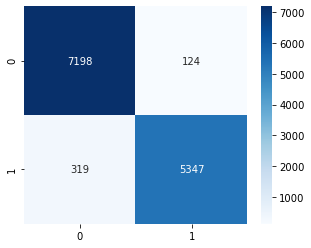

In [59]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsBagging), cmap = "Blues", annot=True, fmt = '.0f')

In [60]:
print(classification_report(y_test, predictionsBagging))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7322
           1       0.98      0.94      0.96      5666

    accuracy                           0.97     12988
   macro avg       0.97      0.96      0.97     12988
weighted avg       0.97      0.97      0.97     12988



In [61]:
#Psting
start_timePasting = time.time()
modelPasting = BaggingClassifier(modelXGBoost, n_estimators = 100, bootstrap = False)
modelPasting.fit(X_train, y_train)
predictionsPasting = modelPasting.predict(X_test)
accuracyPasting = metrics.accuracy_score(y_test, predictionsPasting)
print("Accuracy: ", accuracyPasting)
timePasting = time.time() - start_timePasting
print("Time taken to achive result: %s seconds" % (timePasting))

Accuracy:  0.9655066214967662
Time taken to achive result: 359.9447295665741 seconds


<AxesSubplot:>

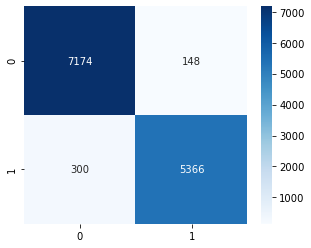

In [62]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsPasting), cmap = "Blues", annot=True, fmt = '.0f')

In [63]:
print(classification_report(y_test, predictionsPasting))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7322
           1       0.97      0.95      0.96      5666

    accuracy                           0.97     12988
   macro avg       0.97      0.96      0.96     12988
weighted avg       0.97      0.97      0.97     12988



The last ensemble method we will evaluate is the <b>Stacking Classifier</b>. This uses the simple yet elegant idea to take the results given by each predictor for each method, and unlike the voting classifier, build a new model to evaluate them and return an answer, which shall be the final result for the instance for this classifier.

In [64]:
#Stacking
start_timeStacking = time.time()
modelStacking = StackingClassifier(estimators= [('KNN', modelKNN),
                                      ('LogReg', modelLogReg),
                                      ('RandForests', modelRandForests),
                                      ('AdaBoost', modelAdaBoost),
                                      ('XGBoost', modelXGBoost)], 
                         final_estimator=LogisticRegression())
modelStacking.fit(X_train, y_train)
predictionsStacking = modelStacking.predict(X_test)
accuracyStacking = metrics.accuracy_score(y_test, predictionsStacking)
print("Accuracy: ", accuracyStacking)
timeStacking = time.time() - start_timeStacking
print("Time taken to achive result: %s seconds" % (timeStacking))

Accuracy:  0.9651986449029873
Time taken to achive result: 759.5865070819855 seconds


<AxesSubplot:>

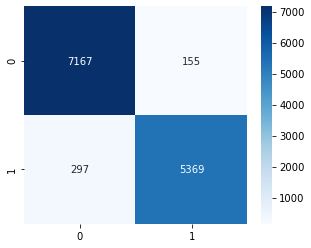

In [65]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsStacking), cmap = "Blues", annot=True, fmt = '.0f')

In [66]:
print(classification_report(y_test, predictionsStacking))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7322
           1       0.97      0.95      0.96      5666

    accuracy                           0.97     12988
   macro avg       0.97      0.96      0.96     12988
weighted avg       0.97      0.97      0.97     12988



Now that we have trained, fitted, and seen each model, we must decide which of the models to categorize as "best", for which we will analyze the runtime and accuracy of each model. Of course, in commercial projects, the choice will be much more dependent on the type of project and its purposes, as well as the hardware available.

Below is the ROC Curve for the classifiers that we have tried (ROC curve explained in full in the [first half](#ROC) of this notebook), but as we can see, this graph does not tell us much, as most of the models overlap and their accuracy is very close to one another. The ROC Curve's "only concern" is the accuracy of the classifier, but we wish to evaluate the best classifier in terms of effectiveness (accuracy vs. runtime), so the ROC Curve is of limited use.

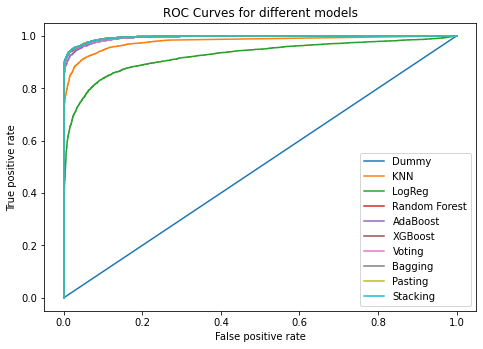

In [67]:
probsKNN = modelKNN.predict_proba(X_test)[:, 1]
probsLogReg = modelLogReg.predict_proba(X_test)[:, 1]
dummyProbs = dummyModel.predict_proba(X_test)[:, 1]
probsRandomForests = modelRandForests.predict_proba(X_test)[:, 1]
probsAdaBoost = modelAdaBoost.predict_proba(X_test)[:, 1]
probsXGBoost = modelXGBoost.predict_proba(X_test)[:, 1]
probsVoting = modelVoting.predict_proba(X_test)[:, 1]
probsBagging = modelBagging.predict_proba(X_test)[:, 1]
probsPasting = modelPasting.predict_proba(X_test)[:, 1]
probsStacking = modelStacking.predict_proba(X_test)[:, 1]

fprLogReg, tprLogReg, thresholdsLogReg = metrics.roc_curve(y_test, probsLogReg)
fprKNN, tprKNN, thresholdsKNN = metrics.roc_curve(y_test, probsKNN)
fprDummy, tprDummy, thresholdsDummy = metrics.roc_curve(y_test, dummyProbs)
fprRandFor, tprRandFor, thresholdsRandFor = metrics.roc_curve(y_test, probsRandomForests)
fprAdaB, tprAdaB, thresholdsAdaB = metrics.roc_curve(y_test, probsAdaBoost)
fprXGB, tprXGB, thresholdsXGB = metrics.roc_curve(y_test, probsXGBoost)
fprVot, tprVot, thresholdsVot = metrics.roc_curve(y_test, probsVoting)
fprBag, tprBag, thresholdsBag = metrics.roc_curve(y_test, probsBagging)
fprPas, tprPas, thresholdsPas = metrics.roc_curve(y_test, probsPasting)
fprSta, tprSta, thresholdsSta = metrics.roc_curve(y_test, probsStacking)

fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(fprDummy, tprDummy, label = "Dummy")
axes.plot(fprKNN, tprKNN, label = "KNN")
axes.plot(fprLogReg, tprLogReg, label = "LogReg")
axes.plot(fprRandFor, tprRandFor, label = "Random Forest")
axes.plot(fprAdaB, tprAdaB, label = "AdaBoost")
axes.plot(fprXGB, tprXGB, label = "XGBoost")
axes.plot(fprVot, tprVot, label = "Voting")
axes.plot(fprBag, tprBag, label = "Bagging")
axes.plot(fprPas, tprPas, label = "Pasting")
axes.plot(fprSta, tprSta, label = "Stacking")

axes.set_xlabel("False positive rate")
axes.set_ylabel("True positive rate")
axes.set_title("ROC Curves for different models")
axes.legend()

Next, we will create a table (a dataframe), that will show us the considered data, to help us define the best classifier out of all. Although the table is very helpful, it is still quite hard to see the differences between the accuracies of the classifiers (though quite easy to see the differences of runtime).

In [68]:
results = pd.DataFrame(np.array([['Dummy', accuracyDummy, '---'],
                            ['KNN', accuracyKNN, '---'],
                            ['Logistic Regression', accuracyLogReg, '---'],
                            ['Random Forests', accuracyRandForests, timeRandForests],
                            ['AdaBoost', accuracyAdaBoost, timeAdaBoost],
                            ['XGBoost', accuracyXGBoost, timeXGBoost],
                            ['Voting', accuracyVoting, timeVoting],
                            ['Bagging', accuracyBagging, timeBagging],
                            ['Pasting', accuracyPasting, timePasting],
                            ['Stacking', accuracyStacking, timeStacking]]),
                  columns=['Model', 'Accuracy', 'Runtime (Seconds)'])
resultsView = results.style.set_properties(**{'text-align': 'left'})
resultsView

,Model,Accuracy,Runtime (Seconds)
0,Dummy,0.5637511549122267,---
1,KNN,0.9335540498922081,---
2,Logistic Regression,0.8728826609177702,---
3,Random Forests,0.9634277794887589,8.866713523864746
4,AdaBoost,0.9575762242069603,105.26763963699341
5,XGBoost,0.9655066214967662,3.468726396560669
6,Voting,0.9654296273483215,148.0000650882721
7,Bagging,0.9658915922389898,360.38956689834595
8,Pasting,0.9655066214967662,359.9447295665741
9,Stacking,0.9651986449029873,759.5865070819855


We will plot a bar graph to help us see the accuracies better. Again, the differences here are minor, so the graph is of limited use. We can determine that that the Dummy Classifier and Logistic Regression perform much worse than the rest. 

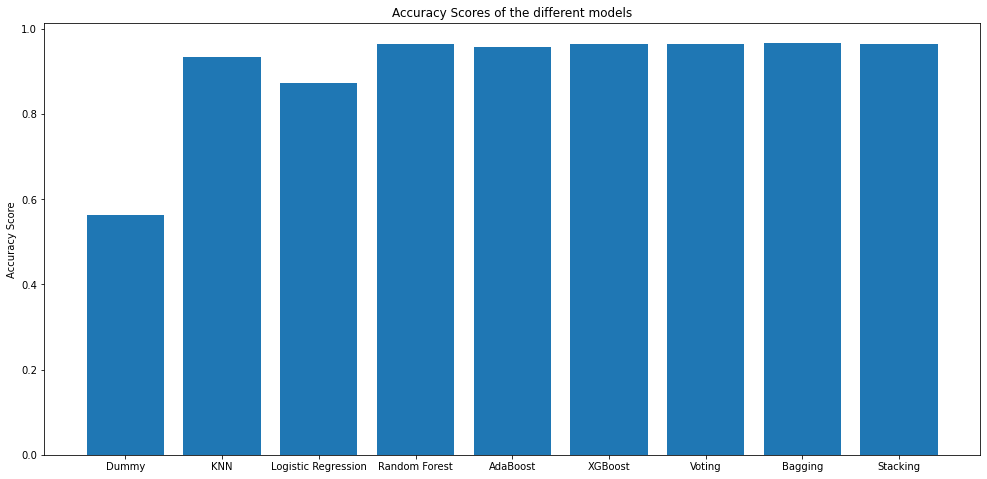

In [69]:
fig = plt.figure(figsize=(13,6))

accuracies = [accuracyDummy, accuracyKNN, accuracyLogReg, accuracyRandForests, accuracyAdaBoost, accuracyXGBoost,
             accuracyVoting, accuracyBagging, accuracyPasting, accuracyStacking]
accuraciesSize = np.arange(len(accuracies))
axes = fig.add_axes([0,0,1,1])
axes.bar(['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
          'Pasting', 'Stacking'], accuracies)
axes.set_ylabel("Accuracy Score")
axes.set_title("Accuracy Scores of the different models")
plt.rcParams['xtick.labelsize'] = 10

In the graph below, we try to zoom in the graph above (by limiting the y axis). As we can see, The Dummy Classifier, KNN and Logistic Regression models are not even in the range specified, hence invisible in the graph. The rest of the models, although still very close, can be distinguished and we can see that the most accurate classifier is the Bagging Classifier, next being XGBoost, Voting and Stacking (in that order). That being said, the difference between these four classifiers is very minor.

(0.957, 0.9664)

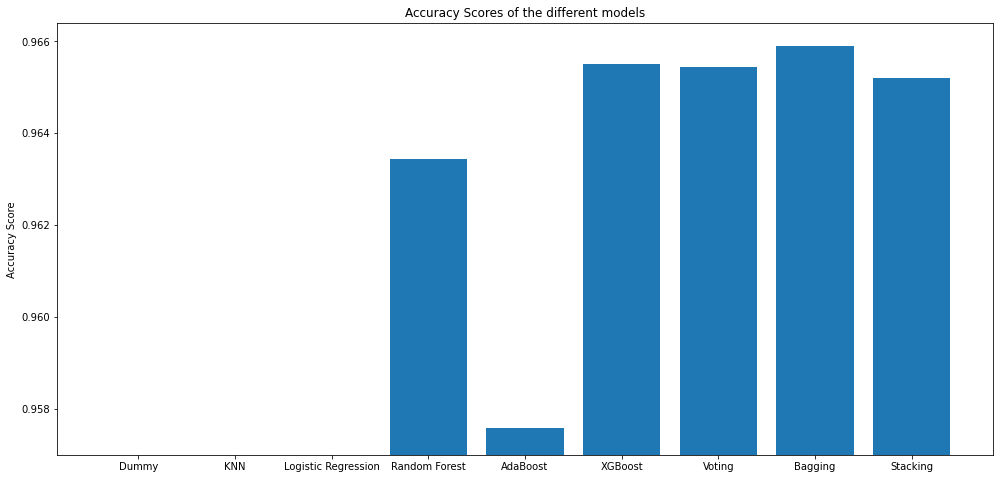

In [70]:
fig = plt.figure(figsize=(13,6))

accuracies = [accuracyDummy, accuracyKNN, accuracyLogReg, accuracyRandForests, accuracyAdaBoost, accuracyXGBoost,
             accuracyVoting, accuracyBagging, accuracyPasting, accuracyStacking]
accuraciesSize = np.arange(len(accuracies))
axes = fig.add_axes([0,0,1,1])
axes.bar(['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
          'Pasting', 'Stacking'], accuracies)
axes.set_ylabel("Accuracy Score")
axes.set_title("Accuracy Scores of the different models")
plt.rcParams['xtick.labelsize'] = 10
axes.set_ylim([0.957, 0.9664])

Next, The bar graph for the runtimes is shown. We can identify the Bagging Classifier as the one with the longest runtime, while The Dummy, KNN, Logistic Regression and Random Forests classifiers had the best runtime.

In [ ]:
def timeGraph():
    fig = plt.figure(figsize=(13,6))

    time = [timeDummy, timeKNN, timeLogReg, timeRandForests, timeAdaBoost, timeXGBoost,
             timeVoting, timeBagging, timePasting, timeStacking]
    timeSize = np.arange(len(time))
    axes = fig.add_axes([0,0,1,1])
    labels = ['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
              'Pasting', 'Stacking']
    axes.bar(labels, time)
    axes.set_ylabel("Runtime (Seconds)")
    axes.set_title("Runtimes of the Different Classifiers")
    plt.rcParams['xtick.labelsize'] = 10
    
timeGraph()

In [71]:
resultsView

,Model,Accuracy,Runtime (Seconds)
0,Dummy,0.5637511549122267,---
1,KNN,0.9335540498922081,---
2,Logistic Regression,0.8728826609177702,---
3,Random Forests,0.9634277794887589,8.866713523864746
4,AdaBoost,0.9575762242069603,105.26763963699341
5,XGBoost,0.9655066214967662,3.468726396560669
6,Voting,0.9654296273483215,148.0000650882721
7,Bagging,0.9658915922389898,360.38956689834595
8,Pasting,0.9655066214967662,359.9447295665741
9,Stacking,0.9651986449029873,759.5865070819855


Below is a combined graph showing both accuracies and runtimes of each classifier (left y-axis: runtime (seconds), right y-axis: accuracy):

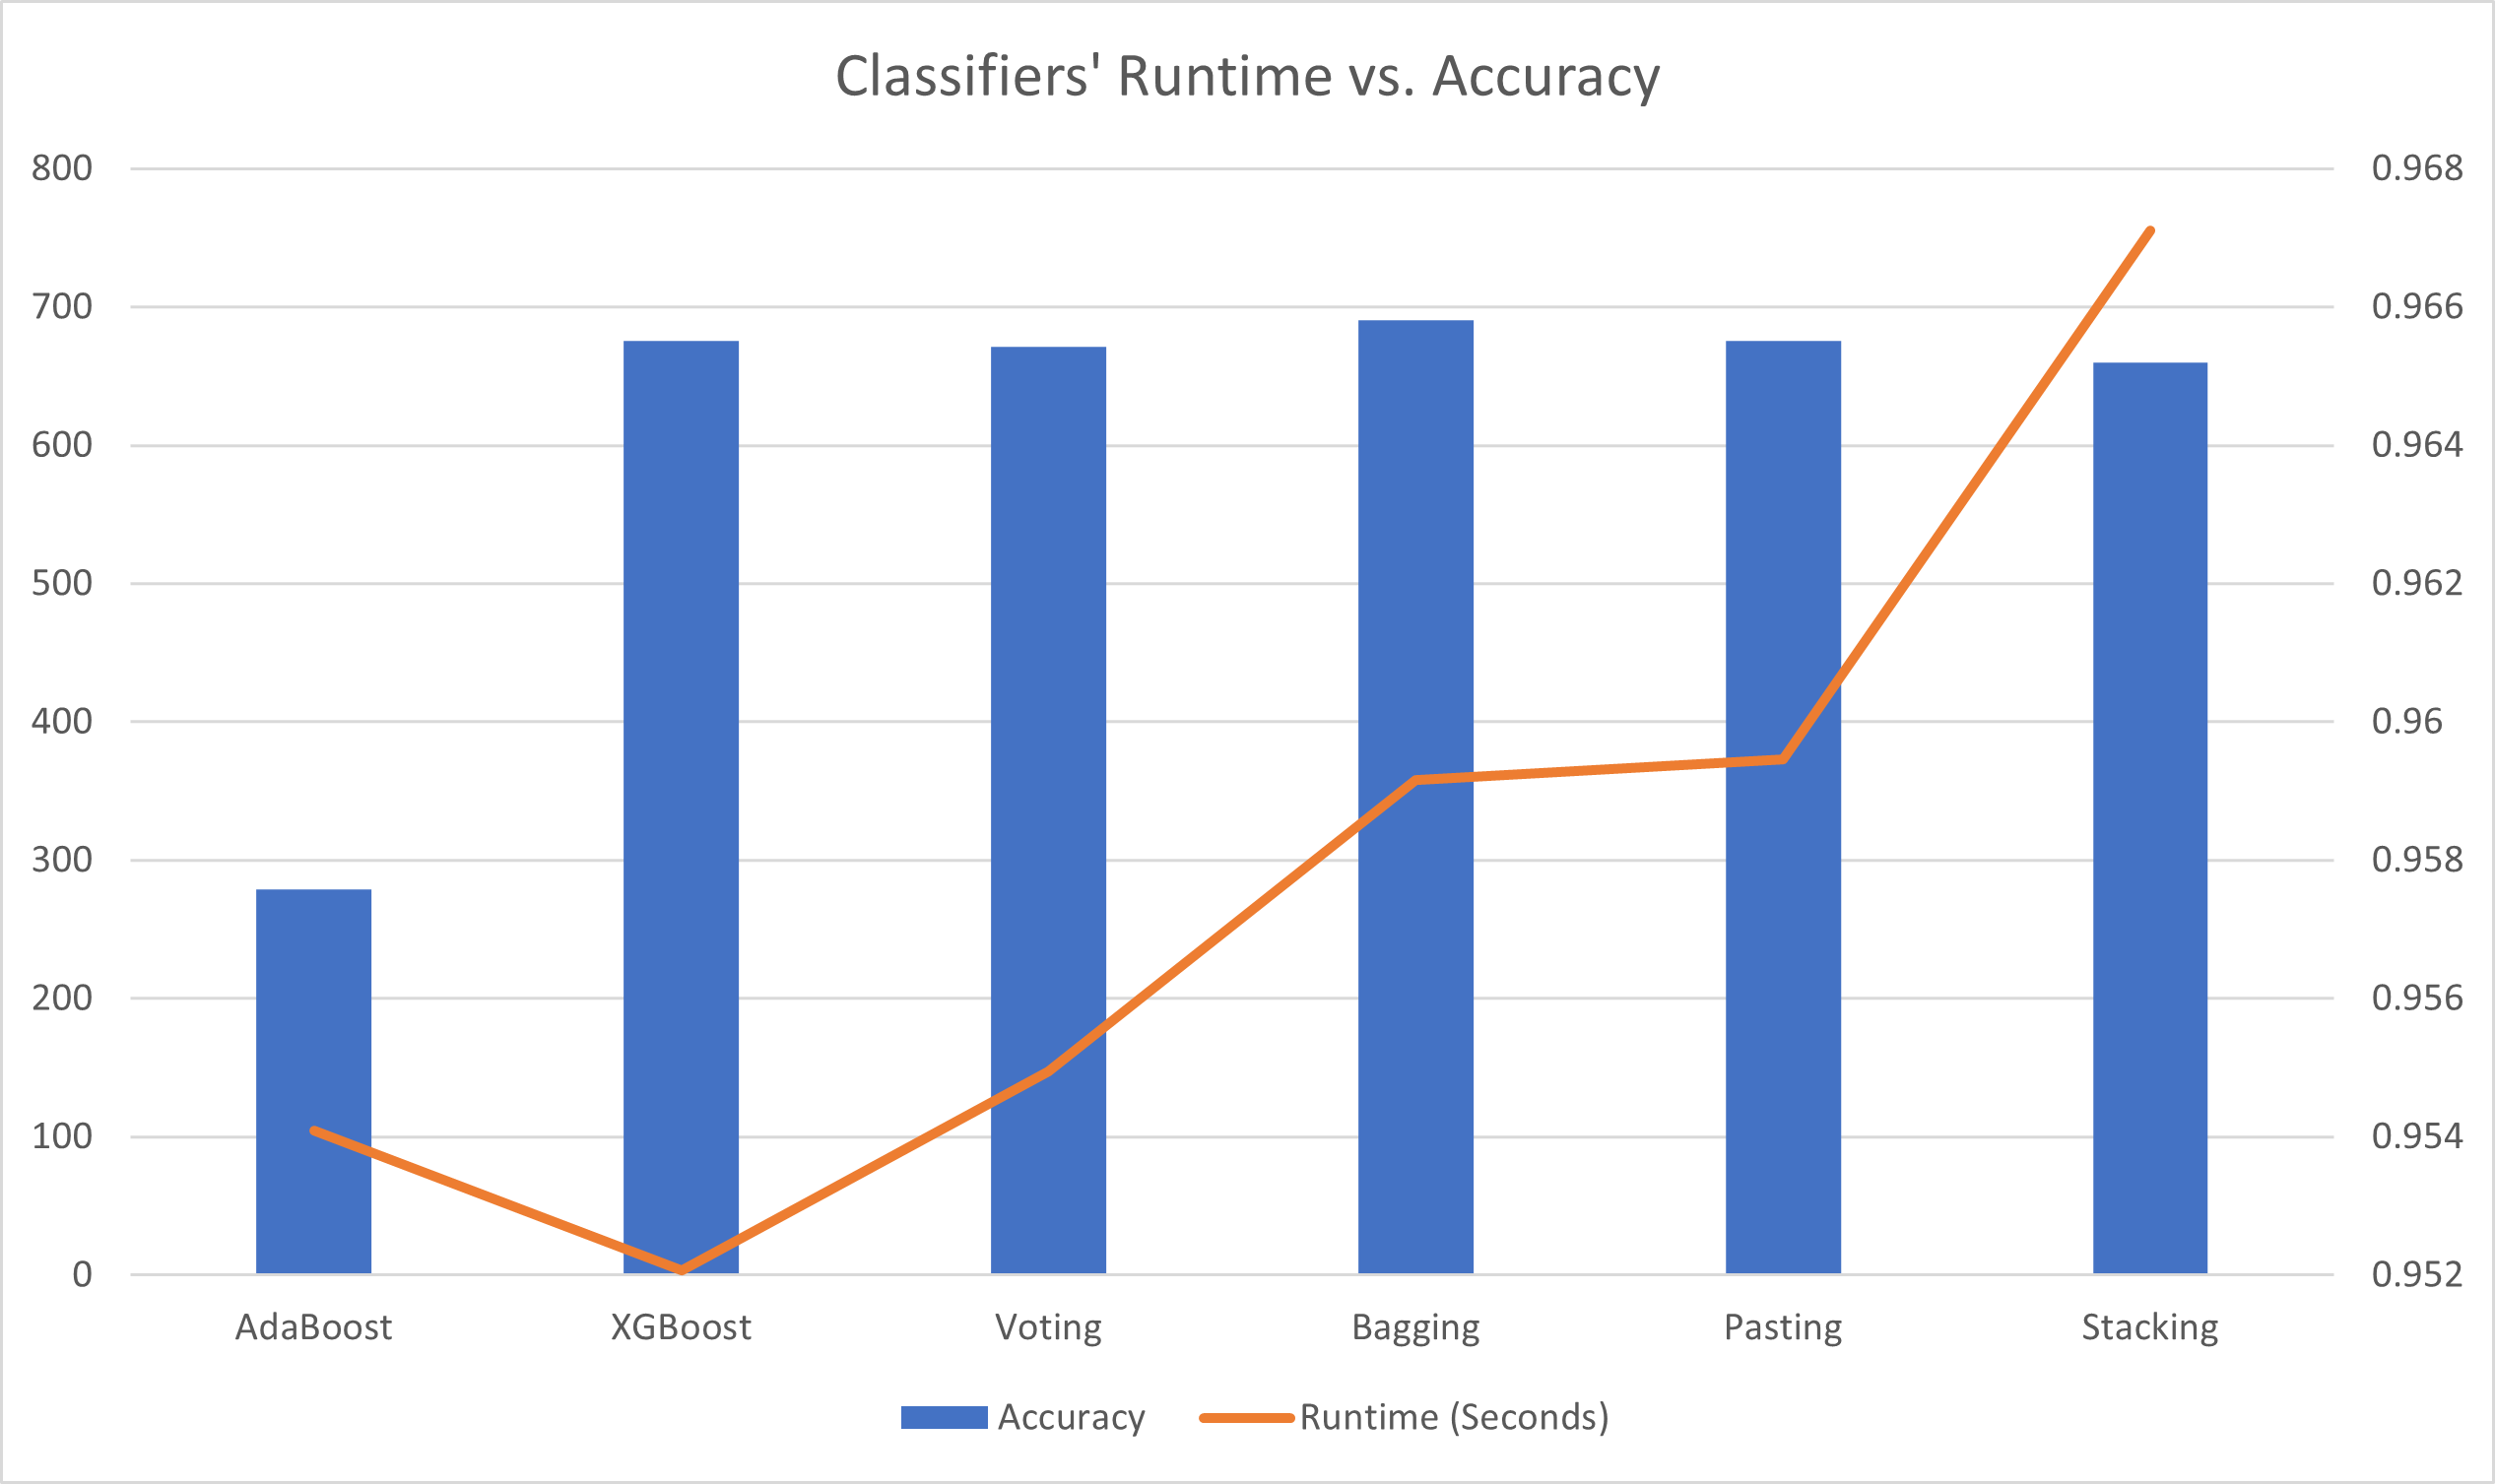

##### Mid-Way Conclusion

Now that we have determined the most accurate classifier, we can have a look at the runtimes of each classifier. We can see that the bagging classifier (best in regards of accuracy) takes around 350 seconds, whereas the XGBoost classifier gives almost the same accuracy (difference of around 0.0003) while taking only 3 seconds to achieve the results! This makes the XGBoost Classifier the best to use in almost all cases (exceptions may be when accuracy is of the utmost importance).

## PCA (Principal Component Analysis)

<b>Dimensionality Reduction:</b><br>
When working with data which has many dimensions, it is often wise to attempt to quicken the classifiers by reducing the number of dimensions used to fit the data. Clearly, the removal of some dimensions will cause the classifier to perform worse than if it were run on the full data, but it can be very beneficial due to it expediting the runtime of the program dramatically. The problem occurs when we try to choose which dimensions to remove from examination, as it could be the feature having a crucial impact on the results of our classifier. This is what the PCA attempts to help us choose.

<b>What is PCA?</b><br>
The PCA algorithm attempts to help us use dimensionality reduction to reduce runtime while slightly reducing the accuracy of the classifiers. Using some linear algebra, the algorithm chooses the number of dimensions (as can be specified using the n_components hyperparameter) which are the most useful for the classifiers. When n_components is set to a value between 0 and 1, the algorithm covers the percentage of variance specified (very useful, as it is making the PCA flexible for different data, or for approximating the accuracy drop of the final classifier).

The PCA should be trained and fitted on the training set, and then the trained PCA should be used to transform both the training and the testing set. Training the PCA on the test set is not right, as it means that we are using both the training and testing to fit the data to a certain shape, while analyzing it as a whole, which is incorrect, as the test set should only be used to test the results.<br>
Despite that, the test set still has to be changed according to what the PCA has fitted on the training set, due to all classifiers requiring the data to be of the same shape in order to work on them.

In [72]:
pca = PCA(n_components=0.9)
X_train_Reduced = pca.fit_transform(X_train)
X_test_Reduced = pca.transform(X_test)

Now that the PCA is trained and we have transformed the data into what the PCA has determined, we can run the classifiers again, to check and see how they perform. We shall use two of the classifiers to start with and see what happens.

In [73]:
#XGBoost after PCA
start_timeXGBoostPCA = time.time()
warnings.filterwarnings('ignore')
modelXGBoost = XGBClassifier(learning_rate = 0.2, n_estimators = 200, verbosity = 0, use_label_encoder = False, n_jobs = -1)
modelXGBoost.fit(X_train_Reduced, y_train)
predictionsXGBoostPCA = modelXGBoost.predict(X_test_Reduced)
accuracyXGBoostPCA = metrics.accuracy_score(y_test, predictionsXGBoostPCA)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoostPCA = time.time() - start_timeXGBoostPCA
print("Time taken to achive result: %s seconds" % (timeXGBoostPCA))

Accuracy (XGBoost):  0.9655066214967662
Time taken to achive result: 10.491519451141357 seconds


<AxesSubplot:>

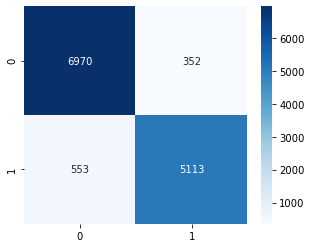

In [74]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoostPCA), cmap = "Blues", annot=True, fmt = '.0f')

In [75]:
print(classification_report(y_test, predictionsXGBoostPCA))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7322
           1       0.94      0.90      0.92      5666

    accuracy                           0.93     12988
   macro avg       0.93      0.93      0.93     12988
weighted avg       0.93      0.93      0.93     12988



In [76]:
#AdaBoost after PCA
start_timeAdaBoostPCA = time.time()
modelDecTree = DecisionTreeClassifier(random_state=0, max_depth=2)
modelAdaBoost = AdaBoostClassifier(modelDecTree, n_estimators = 1000, random_state = 0, learning_rate = 1)
modelAdaBoost.fit(X_train_Reduced, y_train)
predictionsAdaBoostPCA = modelAdaBoost.predict(X_test_Reduced)
accuracyAdaBoostPCA = metrics.accuracy_score(y_test, predictionsAdaBoostPCA)
print("Accuracy (AdaBoost): ", accuracyAdaBoostPCA)
timeAdaBoostPCA = time.time() - start_timeAdaBoostPCA
print("Time taken to achive result: %s seconds" % (timeAdaBoostPCA))

Accuracy (AdaBoost):  0.9141515244841392
Time taken to achive result: 299.69625639915466 seconds


<AxesSubplot:>

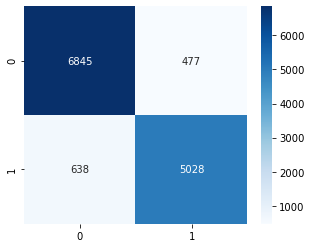

In [77]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsAdaBoostPCA), cmap = "Blues", annot=True, fmt = '.0f')

In [78]:
print(classification_report(y_test, predictionsAdaBoostPCA))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7322
           1       0.91      0.89      0.90      5666

    accuracy                           0.91     12988
   macro avg       0.91      0.91      0.91     12988
weighted avg       0.91      0.91      0.91     12988



Now, for the two classifiers, we can record their results in the table we created.<br>
The results were quite unexpected. We expected the runtime of the program to reduce, as well as the accuracy of the model to drop slightly.<br>
We can see that the accuracy, as expected, was reduced, as was the number of dimensions, meaning the PCA algorithm worked. Despite that, the runtime of the classifiers was not reduced (quite the opposite). This, after much scrupulus research, turns out to be due to most of the data being discrete (having a very limited number of unique values for a feature). PCA, when exposed to such data, performs as expected in all regards but runtime, which increases (in our case the runtime was increased to three times the runtime of the program before PCA). Meaning, put plainly, that PCA is meant to be used (if the purpose is to reduce runtime) only on continuous data, or when the number of unique values in each feature is large.<br>
Note, that the PCA algorithm is still very useful for discrete data if we want to minimize data size while maximizing accuracy. This is not the case for us, as we wished to reduce runtime.

As a partial summary, (explained in full in the conclusion and above), we can understand that the best classifier for our needs is the XGBoost. To further improve its performance, we can try to run a Grid Search in order to find the best hyperparameters for the job (Our metric being the accuracy of the model). The Grid Search runs the classifier on all options as specified in "parameters" and running cross validation on them, and can return the best option out of all. We choose to check the 2 most important (in my opinion and in many cases) hyperparameters: learning rate and number of estimators (checking more hyperparameters will result in too many iterations of the grid search, increasing the runtime drastically). The Grid Search was run once, its results recorded (and printed below), in order to reduce the overall runtime of the program.

In [1]:
def GridSearchXGBoost():
    paramsXGBoost = {
        'learning_rate': [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'n_estimators': list(range(50, 1050, 50))
    }
    gridSearch = GridSearchCV(modelXGBoost, paramsXGBoost, cv=10, scoring='accuracy')


    start_timeGS = time.time()
    gridSearch.fit(X_train, y_train)
    timeGS = time.time() - start_timeGS
    print("Time taken to achive result: %s seconds" % (timeGS))
    pd.DataFrame(gridSearch.cv_results_)[['Average score', 'std_test_score', 'params']]

    # examine the best model
    print(gridSearch.best_score_)
    print(gridSearch.best_params_)
    

#GridSearchXGBoost()

    
#The results after the run of the function:
print("Best Average Accuracy: 0.9648050981375675 when the parameters were: learning_rate: 0.05 and n_estimators: 950")

Best Average Accuracy: 0.9648050981375675 when the parameters were: learning_rate: 0.05 and n_estimators: 950


When we run the XGBoost on the found hyperparameters, we can see that the accuracy of the classifier has risen to surpass the accuracy of the most accurate classifier up to this point (Bagging), although the average accuracy when run in the grid search was less. The difference is quite minor, but we can guess that the one run in the grid search is the more accurate (as it was run using cross validation). Again, because the differences are minor, we will not go into deciding which estimation of the classifier is better or more accurate (it is an estimation after all).<br>
Still The XGBoost classifier has improved its performance, with the cost of runtime (16 seconds compared to 3 seconds). Whether this difference is significant enough or not to make the changes, there is no definite answer. My personal opinion is that it is.

In [27]:
#Improved XGBoost
start_timeXGBoostNew = time.time()
warnings.filterwarnings('ignore')
modelXGBoostNew = XGBClassifier(learning_rate = 0.05, n_estimators = 950, verbosity = 0, use_label_encoder = False, n_jobs = -1)
modelXGBoostNew.fit(X_train, y_train)
predictionsXGBoostNew = modelXGBoostNew.predict(X_test)
accuracyXGBoostNew = metrics.accuracy_score(y_test, predictionsXGBoostNew)
print("Accuracy (XGBoost): ", accuracyXGBoostNew)
timeXGBoostNew = time.time() - start_timeXGBoostNew
print("Time taken to achive result: %s seconds" % (timeXGBoostNew))
#0.9654296273483215

Accuracy (XGBoost):  0.9659685863874345
Time taken to achive result: 89.27826595306396 seconds


<AxesSubplot:>

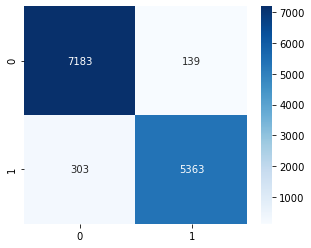

In [85]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoostNew), cmap = "Blues", annot=True, fmt = '.0f')

In [86]:
print(classification_report(y_test, predictionsXGBoostNew))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7322
           1       0.97      0.95      0.96      5666

    accuracy                           0.97     12988
   macro avg       0.97      0.96      0.97     12988
weighted avg       0.97      0.97      0.97     12988



In [83]:
results = pd.DataFrame(np.array([['Dummy', accuracyDummy, '---', '---', '---'],
                            ['KNN', accuracyKNN, '---', '---', '---'],
                            ['Logistic Regression', accuracyLogReg, '---', '---', '---'],
                            ['Random Forests', accuracyRandForests, timeRandForests, '---', '---'],
                            ['AdaBoost', accuracyAdaBoost, timeAdaBoost, accuracyAdaBoostPCA, timeAdaBoostPCA],
                            ['XGBoost - before Grid Search', accuracyXGBoost, timeXGBoost, accuracyXGBoostPCA, timeXGBoostPCA],
                            ['XGBoost - after Grid Search', accuracyXGBoostNew, timeXGBoostNew, '---', '---'],
                            ['Voting', accuracyVoting, timeVoting, '---', '---'],
                            ['Bagging', accuracyBagging, timeBagging, '---', '---'],
                            ['Pasting', accuracyPasting, timePasting, '---', '---'],
                            ['Stacking', accuracyStacking, timeStacking, '---', '---']]),
                  columns=['Model', 'Accuracy', 'Runtime (Seconds)', 'PCA Accuracy', 'PCA Runtime (Seconds)'])
resultsView = results.style.set_properties(**{'text-align': 'left'})
resultsView

,Model,Accuracy,Runtime (Seconds),PCA Accuracy,PCA Runtime (Seconds)
0,Dummy,0.5637511549122267,---,---,---
1,KNN,0.9335540498922081,---,---,---
2,Logistic Regression,0.8728826609177702,---,---,---
3,Random Forests,0.9634277794887589,8.866713523864746,---,---
4,AdaBoost,0.9575762242069603,105.26763963699341,0.9141515244841392,299.69625639915466
5,XGBoost - before Grid Search,0.9655066214967662,3.468726396560669,0.93032029565753,10.491519451141357
6,XGBoost - after Grid Search,0.9659685863874345,15.806080341339111,---,---
7,Voting,0.9654296273483215,148.0000650882721,---,---
8,Bagging,0.9658915922389898,360.38956689834595,---,---
9,Pasting,0.9655066214967662,359.9447295665741,---,---


Below is the same table from above sorted by the accuracies of the models.

In [84]:
results = results.sort_values(by = 'Accuracy', axis = 0, ascending = False)
resultsView = results.style.set_properties(**{'text-align': 'left'})
resultsView

,Model,Accuracy,Runtime (Seconds),PCA Accuracy,PCA Runtime (Seconds)
6,XGBoost - after Grid Search,0.9659685863874345,15.806080341339111,---,---
8,Bagging,0.9658915922389898,360.38956689834595,---,---
5,XGBoost - before Grid Search,0.9655066214967662,3.468726396560669,0.93032029565753,10.491519451141357
9,Pasting,0.9655066214967662,359.9447295665741,---,---
7,Voting,0.9654296273483215,148.0000650882721,---,---
10,Stacking,0.9651986449029873,759.5865070819855,---,---
3,Random Forests,0.9634277794887589,8.866713523864746,---,---
4,AdaBoost,0.9575762242069603,105.26763963699341,0.9141515244841392,299.69625639915466
1,KNN,0.9335540498922081,---,---,---
2,Logistic Regression,0.8728826609177702,---,---,---


### Conclusion

Throughout the data and the notebook, we have tried to find the best model for our data, with the objectives to optimize accuracy and runtime as best we can. We have tried many models, the results of which are displayed above. Due to the PCA not improving the performance of the models with our objectives in mind, we can conclude that the XGBoost classifier with the correced hyperparameters after Grid Search is the best classifier we have reviewed, although the original XGBoost may also be considered best.<br>

Moreover, we can determine that the Confusion Matrices presented throughout the notebook have determined that, considering the data was not equally balaced to begin with, the classifiers are not biased (roughly the same percentage of errors for both classes).

Comparing to the work of the last semeste, we have managed to increase the accuracy of our classifiers by roughly 3% (from 0.93 to 0.96) with the use of ensemble learning.

If our objective was to use the most accurate model, with no regard to runtime, the best model would have been undoubtedly the Bagging classifier or the XGBoost Classifier with the corrected hyperparameters (to answer definitively requires more research and the difference is extremely minor).<br>

If our objective was to optimize the data for data size and any combination of accuracy and runtime, extensive calculations, and trials with the use of PCA would have had to have been performed (were not performed in this notebook).<br>

As mentioned before, this notebook was done mostly for educational purposes, with all aspects and all classifiers shown and explained fully. Generally, a classifier will be chosen according to the needs and the limitations of the project and hardware.